# Cell width

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Imports

In [265]:
%load_ext autoreload
%autoreload 2
import sys 

# sys.path.append('..')
from omegaconf import OmegaConf
from pprint import pprint
from dacite import from_dict
from dacite import Config as DaciteConfig
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pandas as pd
import numpy as np

import math
from abc import abstractmethod

from xlstm.xlstm_block_stack import xLSTMBlockStack, xLSTMBlockStackConfig
from xlstm.utils import WeightDecayOptimGroupMixin

from xlstm_moex.data.download import get_historical_data

device = "cuda:0" if torch.cuda.is_available() else "cpu"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fucntions and classes

In [243]:
class BaseLRScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, last_epoch=-1):
        super().__init__(optimizer, last_epoch)

    @abstractmethod
    def get_lr(self) -> list[float]:
        """Returns the current learning rate for each parameter group."""
        raise NotImplementedError

    @abstractmethod
    def reinitialize(self, **kwargs) -> None:
        """Reinitializes the learning rate scheduler."""
        raise NotImplementedError


class LinearWarmupCosineAnnealing(BaseLRScheduler):
    def __init__(self, optimizer, warmup_steps, decay_until_step, max_lr, min_lr, last_epoch=-1):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.decay_until_step = decay_until_step
        self.min_lr = min_lr
        self.max_lr = max_lr
        super().__init__(optimizer, last_epoch)

    @staticmethod
    def compute_lr(step, warmup_steps, decay_until_step, max_lr, min_lr):
        if step < warmup_steps:
            return max_lr * step / warmup_steps
        if step > decay_until_step:
            return min_lr
        if warmup_steps <= step < decay_until_step:
            decay_ratio = (step - warmup_steps) / (decay_until_step - warmup_steps)
            assert 0.0 <= decay_ratio <= 1.0
            coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
            return min_lr + coeff * (max_lr - min_lr)
        else:
            return min_lr

    def get_lr(self) -> list[float]:
        """Returns the current learning rate for each parameter group."""
        step = self.last_epoch
        return (
            self.compute_lr(step, self.warmup_steps, self.decay_until_step, self.max_lr, self.min_lr)
            for _ in self.optimizer.param_groups
        )

# Init config

In [2]:
# xlstm_cfg = f""" 
# mlstm_block:
#   mlstm:
#     conv1d_kernel_size: 4
#     qkv_proj_blocksize: 1
#     num_heads: 1
#     proj_factor: 1
# slstm_block:
#   slstm:
#     backend: {'cuda' if torch.cuda.is_available() else 'vanilla'} #! only vanilla here works
#     num_heads: 1
#     conv1d_kernel_size: 0
#     bias_init: powerlaw_blockdependent
#   feedforward:
#     proj_factor: 1.2
#     act_fn: gelu
# context_length: 50
# num_blocks: 2
# embedding_dim: 1 # same as `in_features` in Pytorch LSTM
# slstm_at: [1] #[1] # for [] it also works, so if no sLSTM is in the stack
# """

xlstm_cfg = f""" 
mlstm_block:
  mlstm:
    conv1d_kernel_size: 4
    qkv_proj_blocksize: 4
    num_heads: 4
slstm_block:
  slstm:
    backend: {'cuda' if torch.cuda.is_available() else 'vanilla'} #! only vanilla here works
    num_heads: 4
    conv1d_kernel_size: 4
    bias_init: powerlaw_blockdependent
  feedforward:
    proj_factor: 1.3
    act_fn: gelu
context_length: 256
num_blocks: 7
embedding_dim: 128
add_post_blocks_norm: False
slstm_at: [1] #[1] # for [] it also works, so if no sLSTM is in the stack
"""

# Init XLSTM model

In [3]:
cfg = OmegaConf.create(xlstm_cfg)
cfg = from_dict(data_class=xLSTMBlockStackConfig, data=OmegaConf.to_container(cfg), config=DaciteConfig(strict=True))
xlstm_stack = xLSTMBlockStack(cfg)

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/nick/anaconda3/envs/nxai_xlstm/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vect

Using /home/nick/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/nick/.cache/torch_extensions/py311_cu121/slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
Building extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


# Inspect config

In [5]:
pprint(cfg.embedding_dim)

128


# Inspect layers

In [91]:
xlstm_stack

xLSTMBlockStack(
  (blocks): ModuleList(
    (0): mLSTMBlock(
      (xlstm_norm): LayerNorm()
      (xlstm): mLSTMLayer(
        (proj_up): Linear(in_features=128, out_features=512, bias=False)
        (q_proj): LinearHeadwiseExpand(in_features=256, num_heads=64, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
        (k_proj): LinearHeadwiseExpand(in_features=256, num_heads=64, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
        (v_proj): LinearHeadwiseExpand(in_features=256, num_heads=64, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
        (conv1d): CausalConv1d(
          (conv): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
        )
        (conv_act_fn): SiLU()
        (mlstm_cell): mLSTMCell(
          (igate): Linear(in_features=768, out_features=4, bias=True)
          (fgate): Linear(in_features=768, out_features=4, bias=True)
          (outnorm): Mult

# Generate synthetic examlpe

In [122]:
x = torch.randn(2, 256, 128).to(device=device)

In [123]:
x.shape

torch.Size([2, 256, 128])

In [97]:
x[:, 1, :].view(2,1,128).shape

torch.Size([2, 1, 128])

# Check model's output

In [98]:
xlstm_stack = xlstm_stack.to(device=device)

In [84]:
for i in range(2):
    y, states_dict = xlstm_stack.step(x[:, i, :].view(2,1,128))

In [87]:
states_dict['block_6']

{'mlstm_state': (tensor([[[[ 5.4874e-06, -1.2764e-06, -4.2204e-06,  ..., -1.7712e-05,
             -2.4697e-06, -7.9438e-06],
            [ 4.2978e-05, -9.9968e-06, -3.3054e-05,  ..., -1.3872e-04,
             -1.9342e-05, -6.2216e-05],
            [-2.4128e-05,  5.6123e-06,  1.8557e-05,  ...,  7.7881e-05,
              1.0859e-05,  3.4929e-05],
            ...,
            [-1.0465e-05,  2.4343e-06,  8.0490e-06,  ...,  3.3780e-05,
              4.7100e-06,  1.5150e-05],
            [-3.4788e-05,  8.0919e-06,  2.6756e-05,  ...,  1.1229e-04,
              1.5657e-05,  5.0361e-05],
            [-1.0198e-05,  2.3721e-06,  7.8432e-06,  ...,  3.2916e-05,
              4.5896e-06,  1.4763e-05]],
  
           [[ 1.1881e-04, -4.0994e-04,  2.5100e-04,  ...,  1.2454e-06,
             -2.5543e-04,  3.8301e-04],
            [ 1.7321e-04, -5.9762e-04,  3.6592e-04,  ...,  1.8156e-06,
             -3.7237e-04,  5.5836e-04],
            [ 7.2518e-05, -2.5021e-04,  1.5320e-04,  ...,  7.6015e-07,
     

In [81]:
y.shape

torch.Size([2, 1, 128])

In [82]:
y

tensor([[[-0.4978,  1.5445,  1.2798, -1.4677, -2.1897,  0.7250,  0.6384,
          -0.3543, -0.6553, -0.5294,  0.9895,  0.8925,  0.0369,  0.3600,
           1.0671, -0.8967,  0.7769,  1.7208, -0.9602, -2.3994, -0.3734,
          -0.0866,  1.4061,  0.0087, -0.7891, -0.0173, -1.9538, -0.3937,
          -0.5488, -0.5184,  1.9376, -0.7643, -0.7506,  1.1501, -0.1561,
           0.4513, -1.2406, -0.9217,  0.3434,  0.6700, -0.2392,  0.1344,
          -0.0117, -0.9852, -1.2051,  0.3428, -0.1593, -1.8795, -0.0729,
           1.1581,  0.8664,  0.4295, -0.0295,  0.2280,  1.7564,  0.3873,
          -0.2153,  1.3113,  0.0999,  0.7173, -1.0597, -2.2170,  1.2809,
          -1.7322,  0.5820,  1.3519,  0.9275, -0.4028,  0.1005,  0.5075,
          -0.2481,  0.8091,  0.7399, -0.1949,  0.4818, -0.6697,  0.0183,
           0.0428, -0.2187, -1.7713,  1.3467, -1.7573,  0.5467,  1.1787,
           1.0028, -0.7336,  1.9220,  0.9596, -0.5030, -1.3327,  1.2682,
           0.0318,  0.2944, -0.4946, -1.2384, -0.16

In [83]:
x[:, 1, :].view(2,1,128)

tensor([[[-8.8171e-01,  7.5984e-01,  1.3308e+00, -8.0911e-01, -7.1669e-01,
           1.2324e-01,  6.4953e-01,  1.9917e-01, -2.8007e-02,  2.0094e-01,
           8.0642e-01,  1.5618e+00, -3.5212e-01,  3.7325e-02,  9.7363e-01,
          -6.5723e-01, -6.3216e-01, -2.7189e-01, -6.8714e-01, -2.0393e+00,
          -3.4308e-02,  9.7309e-01, -2.3616e-01, -3.9586e-01, -6.4092e-02,
           9.2531e-01, -2.7790e+00, -6.8198e-01, -1.6832e-02, -2.0715e-01,
           2.5983e+00, -7.3946e-01, -1.0449e+00,  7.0546e-01,  1.0123e+00,
           7.0937e-01, -5.6492e-01, -1.9830e+00, -2.7441e-01,  8.7571e-01,
           1.7398e-02,  9.0983e-01,  1.3253e-01,  4.8852e-02, -1.4840e+00,
          -2.9523e-02,  1.3925e+00,  1.0114e-01,  3.2748e-01,  1.0978e+00,
          -8.5351e-01, -3.0628e-01, -4.6161e-01, -3.8436e-01,  1.0335e+00,
           6.7830e-01, -3.3133e-01,  6.6896e-01, -4.6368e-01,  7.4131e-01,
          -1.6848e+00, -1.2495e+00,  1.8919e+00, -6.0618e-01,  2.2224e+00,
           9.6635e-01,  4

In [124]:
y = xlstm_stack(x)

In [125]:
x[:, -1, :]

tensor([[-0.8839,  0.6531, -0.8390, -0.1645,  1.6704,  0.5127, -0.0529,  0.2271,
         -2.5904,  1.3150,  0.3769, -0.1745,  0.2888,  0.9407, -0.1206,  0.6557,
          0.1330,  0.1118,  0.4273,  0.5373, -0.3927, -0.0368, -0.3819,  1.1103,
          0.2225,  0.5210, -0.3059, -0.2255, -0.9224, -0.4568, -2.2560,  1.0137,
         -0.1084, -0.6037,  0.5965, -0.5597, -0.5377, -0.5736,  0.8941, -2.7295,
          1.3067,  0.7518,  0.9739,  0.5398, -0.4596,  0.3005, -0.3543, -0.9072,
          0.3558,  0.1623,  0.5433, -0.9490,  0.1389, -1.0022, -1.1491, -0.3044,
         -0.1395, -0.2475, -0.1755,  0.2795,  1.3190,  0.0260, -0.0259, -0.6402,
         -0.3443, -1.1712,  0.2273, -0.3507,  1.4633, -0.2927,  1.0462,  1.0782,
          0.0841, -0.4016,  0.4079,  0.1693,  0.1225,  0.6326,  0.0118, -1.4028,
         -1.1295,  0.6233,  0.1547,  0.0442, -0.7434, -0.5714, -0.8025,  0.6202,
          0.8696,  1.3488,  0.3080,  0.0314, -0.9079, -0.9560, -0.4306,  0.1162,
         -0.6938,  0.3198, -

In [126]:
y[:, -1, :]

tensor([[-8.8777e-01,  7.0733e-01, -1.1354e+00,  6.8297e-02,  1.2867e+00,
          8.6632e-01,  8.6892e-01,  9.2484e-01, -1.2396e+00,  1.7039e+00,
         -1.0790e+00, -1.0183e+00, -6.6037e-01,  3.6460e-01,  9.4218e-01,
         -9.8400e-02, -1.5814e+00,  4.7198e-01,  1.7564e+00,  1.6153e+00,
          2.3493e-01,  2.9874e-01, -6.3176e-01,  7.8221e-01,  2.1035e+00,
          3.4908e-01, -2.4726e+00,  9.4857e-01, -6.0690e-01,  6.2530e-01,
         -4.8214e+00,  1.9170e+00, -3.0467e-01, -5.0227e-01,  8.7043e-01,
         -4.5736e-01,  4.8147e-03, -5.5708e-01,  2.0257e-01, -2.0661e+00,
          9.1403e-01,  1.8090e+00,  2.6168e-01,  1.3294e+00, -2.0494e+00,
         -1.7052e+00, -5.7928e-01, -7.9424e-01,  9.7212e-01,  2.6963e-01,
          2.0599e+00,  3.2527e-02,  1.6426e+00, -1.7454e+00,  1.4678e+00,
         -6.0697e-01,  5.2550e-01,  4.7229e-01, -5.6340e-01, -1.4185e+00,
          1.2872e+00, -1.8675e+00, -5.2358e-01, -6.4815e-01, -3.6819e-01,
         -1.1029e+00,  3.5903e-01, -6.

In [100]:
y.shape

torch.Size([2, 256, 128])

In [54]:
pprint(y)

tensor([[[ 0.8577, -1.1099, -0.3923,  ...,  0.0940,  0.0937,  0.7333],
         [ 0.8142,  0.0359,  0.3861,  ..., -0.1010, -0.7600, -0.0066],
         [ 2.4055, -1.4971,  0.7610,  ..., -0.5647,  1.4988, -1.2182],
         ...,
         [-1.9958,  0.2881,  0.2207,  ...,  0.1564, -1.6645, -0.3780],
         [-0.4549,  0.3158, -0.3409,  ...,  0.4510, -0.3832,  1.3363],
         [-0.8845, -0.6907,  0.5125,  ...,  1.1808, -1.4142,  1.1701]],

        [[ 0.8740, -2.0196,  0.3545,  ..., -0.7747, -0.1946, -1.2063],
         [-0.3995,  0.4758,  0.2324,  ...,  1.6014, -0.7852,  0.3335],
         [ 0.2124, -0.1924, -0.0830,  ...,  0.5713,  1.6000,  1.5129],
         ...,
         [-0.1742,  1.3780, -0.5989,  ...,  0.0386, -0.5372,  1.5216],
         [ 0.4534,  0.9240, -0.4873,  ...,  0.6691, -0.8149,  1.2498],
         [-0.2121, -0.4231, -1.2146,  ...,  0.4834,  1.7986, -0.7707]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)


In [103]:
pprint(y[:, -1, :].view(1, -1, 128))

tensor([[[ 1.1480, -1.0595,  2.0452, -0.0863, -0.1370,  2.0175, -0.4361,
          -0.1611, -1.5872,  1.1023, -2.6816,  0.6252,  1.0867, -1.2995,
          -0.2884,  1.1804,  1.3891, -1.3155,  0.1274, -3.0621, -4.0834,
           1.0835,  0.5426,  0.4090,  1.8845,  0.7048, -2.5606, -0.6336,
          -0.5072, -0.1934, -0.1107,  4.0092, -0.6715, -0.6509, -1.7275,
           0.2459,  0.1660,  1.4571, -1.2948, -2.2396, -1.9346, -0.5495,
           1.1377, -0.1067,  0.4261, -0.1087, -0.5682,  5.4285,  0.8706,
           1.8102, -1.4242,  0.7603, -0.2171, -1.3306, -0.8624,  1.6319,
          -0.9979, -0.4409,  0.2527, -0.4009, -2.9918, -2.7180,  0.6599,
          -0.0263, -0.8976,  1.0564,  0.7353, -0.1279, -0.2253, -0.8580,
           1.5953, -1.0426,  2.8536, -2.9724, -2.6748,  0.6674,  0.2355,
           0.4488,  3.3318, -1.6286,  0.3944, -1.5674,  0.0701,  0.0965,
           2.1487, -0.0439, -0.0311, -1.9621,  2.6495,  1.4265,  1.3333,
           0.7164, -3.4484, -1.8838, -0.6050,  2.54

In [92]:
t = ()
for i in range(5):
    t += (i,)

In [93]:
t[0]

0

In [128]:
from torch import nn

rnn = nn.LSTM(10, 20, 2, batch_first=True)
inpt = torch.randn(5, 3, 10)
h0 = torch.randn(2, 5, 20)
c0 = torch.randn(2, 5, 20)
output, (hn, cn) = rnn(inpt, (h0, c0))

In [129]:
output.shape

torch.Size([5, 3, 20])

In [130]:
hn.shape

torch.Size([2, 5, 20])

In [121]:
hn[0]

tensor([[-0.2291,  0.0706, -0.2873, -0.0193,  0.0982,  0.1942,  0.0228, -0.1276,
          0.0790,  0.0730, -0.1216,  0.0562,  0.1600,  0.1633, -0.0206, -0.0394,
         -0.0367, -0.0733,  0.1518, -0.1802],
        [-0.1929,  0.1946,  0.0548, -0.1062,  0.0587,  0.0891, -0.0085, -0.0888,
          0.0230,  0.2114,  0.1167,  0.1953,  0.0377, -0.0480, -0.0815,  0.1854,
          0.0207, -0.0434, -0.0672, -0.1421],
        [-0.2902,  0.2361, -0.2112, -0.0509, -0.0608,  0.1652, -0.0098, -0.1355,
          0.1445,  0.1078,  0.0399,  0.1191,  0.0123, -0.0428,  0.0851, -0.0684,
         -0.2345, -0.0469,  0.2690,  0.1379],
        [-0.2975,  0.0864,  0.1136, -0.1358,  0.0094,  0.1324,  0.0084, -0.1017,
         -0.1106,  0.1565, -0.1292,  0.1546, -0.0853, -0.1034,  0.0358,  0.1535,
         -0.0611, -0.0737, -0.1640, -0.1349],
        [-0.0851,  0.1141,  0.2472, -0.2493, -0.1072,  0.0791, -0.1482, -0.1104,
          0.1480,  0.1121,  0.0041,  0.1225,  0.1576,  0.0570, -0.0797, -0.0238,
      

In [119]:
output[:,-1,:]

tensor([[-0.2291,  0.0706, -0.2873, -0.0193,  0.0982,  0.1942,  0.0228, -0.1276,
          0.0790,  0.0730, -0.1216,  0.0562,  0.1600,  0.1633, -0.0206, -0.0394,
         -0.0367, -0.0733,  0.1518, -0.1802],
        [-0.1929,  0.1946,  0.0548, -0.1062,  0.0587,  0.0891, -0.0085, -0.0888,
          0.0230,  0.2114,  0.1167,  0.1953,  0.0377, -0.0480, -0.0815,  0.1854,
          0.0207, -0.0434, -0.0672, -0.1421],
        [-0.2902,  0.2361, -0.2112, -0.0509, -0.0608,  0.1652, -0.0098, -0.1355,
          0.1445,  0.1078,  0.0399,  0.1191,  0.0123, -0.0428,  0.0851, -0.0684,
         -0.2345, -0.0469,  0.2690,  0.1379],
        [-0.2975,  0.0864,  0.1136, -0.1358,  0.0094,  0.1324,  0.0084, -0.1017,
         -0.1106,  0.1565, -0.1292,  0.1546, -0.0853, -0.1034,  0.0358,  0.1535,
         -0.0611, -0.0737, -0.1640, -0.1349],
        [-0.0851,  0.1141,  0.2472, -0.2493, -0.1072,  0.0791, -0.1482, -0.1104,
          0.1480,  0.1121,  0.0041,  0.1225,  0.1576,  0.0570, -0.0797, -0.0238,
      

# Model prototype

## Network

In [266]:
class xLSTMtime(WeightDecayOptimGroupMixin, nn.Module):
    def __init__(self, input_size, output_size, xlstm_blockstack_config):
        super(xLSTMtime, self).__init__()
        self.fc_in = nn.Linear(in_features=input_size, out_features=xlstm_blockstack_config.embedding_dim)
        self.xlstm = xLSTMBlockStack(xlstm_blockstack_config)
        self.fc_out = nn.Linear(in_features=xlstm_blockstack_config.embedding_dim, out_features=output_size)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.xlstm(x)
        x = self.fc_out(x)
        return x
    
    def forecast(self, input_seq, num_steps: int) -> list:
        assert num_steps > 0, '`num_steps` should be greater than zero!'
        batch_size, seq_len, in_features = input_seq.shape
        res_preds = []
        
        for i in range(num_steps):
            next_el = self.forward(input_seq)
            next_el = next_el[:,-1,:].view(batch_size, 1, in_features)
            res_preds.append(next_el)
            input_seq = torch.cat((input_seq, next_el), dim=1)[:, 1:, :] # concatenate along `seq_len` axis
        
        res_preds = torch.cat(res_preds, dim=1).view(num_steps, in_features)
        
        return res_preds
    
    def _create_weight_decay_optim_groups(self, **kwargs):
        weight_decay, no_weight_decay = super()._create_weight_decay_optim_groups(**kwargs)
        # remove token embedding and add it to the correct group, accrording to the config
        weight_decay = list(weight_decay)
        removed = 0
        for idx in range(len(weight_decay)):
            if weight_decay[idx - removed] is self.token_embedding.weight:
                weight_decay.pop(idx - removed)
                removed += 1
        weight_decay = tuple(weight_decay)
        if self.config.weight_decay_on_embedding:
            weight_decay += (self.token_embedding.weight,)
        else:
            no_weight_decay += (self.token_embedding.weight,)

        return weight_decay, no_weight_decay

## Test config

In [748]:
test_cfg_str = f"""
mlstm_block:
  mlstm:
    conv1d_kernel_size: 4
    qkv_proj_blocksize: 4
    num_heads: 4
slstm_block:
  slstm:
    backend: {'cuda' if torch.cuda.is_available() else 'vanilla'} #! only vanilla here works
    num_heads: 4
    conv1d_kernel_size: 4
    bias_init: powerlaw_blockdependent
  feedforward:
    proj_factor: 1.3
    act_fn: gelu
context_length: 50
num_blocks: 4
embedding_dim: 64
add_post_blocks_norm: False
slstm_at: [1] #[1] # for [] it also works, so if no sLSTM is in the stack
"""

training_cfg = {
    'weight_decay': 0.1,
    'lr_warmup_steps': 100,
    'lr_decay_until_steps': 360,
    'lr': 0.001,
    'lr_decay_factor': 0.9,
    'num_steps': 360,
}

test_cfg = OmegaConf.create(test_cfg_str)
test_cfg = from_dict(data_class=xLSTMBlockStackConfig, data=OmegaConf.to_container(test_cfg), config=DaciteConfig(strict=True))

## Init model

In [749]:
xlstmtime = xLSTMtime(
    input_size=1,
    output_size=1,
    xlstm_blockstack_config=test_cfg
)

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/home/nick/anaconda3/envs/nxai_xlstm/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vecto

Using /home/nick/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Creating extension directory /home/nick/.cache/torch_extensions/py311_cu121/slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/nick/.cache/torch_extensions/py311_cu121/slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
Building extension module slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/8] /home/nick/anaconda3/envs/nxai_xlstm/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda_error.cuda.o.d -ccbin /home/nick/anaconda3/envs/nxai_xlstm/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/nick/anaconda3/envs/nxai_xlstm/lib/python3.11/site-packages/torch/include -isystem /home/nick/anaconda3/envs/nxai_xlstm/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/nick/anaconda3/envs/nxai_xlstm/lib/python3.11/site-packages/torch/include/TH -isystem /home/nick/anaconda3/envs/nxai_xlstm/lib/python3.11/site-packages/torch/include/THC -isystem /home/nick/anaconda3/envs/nxai_xlstm/include -isystem /home/nick/anaconda3/envs/nxai_xlstm/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_H

[6/8] /home/nick/anaconda3/envs/nxai_xlstm/bin/nvcc --generate-dependencies-with-compile --dependency-output blas.cuda.o.d -ccbin /home/nick/anaconda3/envs/nxai_xlstm/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/nick/anaconda3/envs/nxai_xlstm/lib/python3.11/site-packages/torch/include -isystem /home/nick/anaconda3/envs/nxai_xlstm/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/nick/anaconda3/envs/nxai_xlstm/lib/python3.11/site-packages/torch/include/TH -isystem /home/nick/anaconda3/envs/nxai_xlstm/lib/python3.11/site-packages/torch/include/THC -isystem /home/nick/anaconda3/envs/nxai_xlstm/include -isystem /home/nick/anaconda3/envs/nxai_xlstm/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CO

Loading extension module slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


In [750]:
xlstmtime = xlstmtime.to(device=device)

## Test input

In [7]:
test_input = torch.randn(2, 50, 1).to(device=device)

In [8]:
test_output = xlstmtime(test_input)

In [9]:
test_output[:,-1,:].shape

torch.Size([2, 1])

In [10]:
test_input[:,-1,:]

tensor([[ 0.3219],
        [-1.0757]], device='cuda:0')

## Test dataloader

In [292]:
# await get_historical_data(
#     output_filename='yndx_20150901_20200901.csv',
#     stock='YNDX',
#     start_date='2015-09-01',
#     end_date='2020-09-01'
# )

2024-10-02 23:11:42,758 - xlstm_moex.data.download - INFO - Finished downloading data, 1261 rows and 23 columns
2024-10-02 23:11:42,767 - xlstm_moex.data.download - INFO - Saved to yndx_20150901_20200901.csv


In [727]:
test_data_raw = (
    pd
    .read_csv('yndx_20150901_20200901.csv')
    .sort_values(by=['TRADEDATE'], ascending=[True])
    ['OPEN']
    .to_list()
)

test_data = [
    test_data_raw[i+1] - test_data_raw[i] for i in range(len(test_data_raw) - 1)
]

# test_data = [
#     (test_data_raw[i+1] - test_data_raw[i])/test_data_raw[i] for i in range(len(test_data_raw) - 1)
# ]

In [728]:
len(test_data)

1260

In [729]:
X_examples = []
y_examples = []
for i in range(len(test_data) - 50 - 1):
    X_examples.append(test_data[i:i+50])
    y_examples.append(test_data[i+50])
X_examples = np.array(X_examples)
y_examples = np.array(y_examples)

In [730]:
X_examples

array([[ -22. ,    8. ,    6. , ...,   16.9,   22.1,   -1. ],
       [   8. ,    6. ,   -2. , ...,   22.1,   -1. ,   20.4],
       [   6. ,   -2. ,    1. , ...,   -1. ,   20.4,  -22.6],
       ...,
       [ 148.2,   40.6,   33.8, ...,   75. ,  120. ,  140.4],
       [  40.6,   33.8,   49.4, ...,  120. ,  140.4,  -66.8],
       [  33.8,   49.4,   62.2, ...,  140.4,  -66.8, -123.4]])

In [731]:
y_examples

array([  20.4,  -22.6,  -21.9, ...,  -66.8, -123.4,   20.4])

In [830]:
np.mean(y_examples)

3.20140612076096

In [831]:
np.std(y_examples)

44.041122294331316

In [751]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.from_numpy(X.astype('float32')).to(device=device).reshape(-1, 50 , 1)
        self.y = torch.from_numpy(y.astype('float32')).to(device=device)
        print(self.X.shape)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index].unsqueeze(0)

In [752]:
dataset = TimeSeriesDataset(X=X_examples, y=y_examples)

torch.Size([1209, 50, 1])


In [753]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=True
)

In [754]:
for X_batch, y_batch in dataloader:
    print(X_batch.shape)
    print(y_batch.shape)
    break

torch.Size([32, 50, 1])
torch.Size([32, 1])


## Test train loop

In [755]:
optimizer = optim.AdamW(
    xlstmtime.parameters(),
    lr=training_cfg['lr'],
)
lr_scheduler = LinearWarmupCosineAnnealing(
    optimizer,
    training_cfg['lr_warmup_steps'],
    training_cfg['lr_decay_until_steps'],
    training_cfg['lr'],
    training_cfg['lr_decay_factor'] * training_cfg['lr'],
)

In [756]:
criterion = nn.MSELoss()
# optimizer = optim.Adam(xlstmtime.parameters(), lr=0.001)

In [757]:
num_epochs = 360
for epoch in range(num_epochs):
    xlstmtime.train()
    for batch_idx, (X_b, y_b) in enumerate(dataloader):
        optimizer.zero_grad()
        y_b_pred = xlstmtime(X_b)
        y_b_pred = y_b_pred[:,-1,:] # select state for last element in sequence
        loss = criterion(y_b_pred, y_b)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        if (batch_idx + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

Epoch [1/360], Batch [5/38], Loss: 1171.3030
Epoch [1/360], Batch [10/38], Loss: 1186.2609
Epoch [1/360], Batch [15/38], Loss: 1329.7394
Epoch [1/360], Batch [20/38], Loss: 5117.0396
Epoch [1/360], Batch [25/38], Loss: 2320.4653
Epoch [1/360], Batch [30/38], Loss: 1572.0469
Epoch [1/360], Batch [35/38], Loss: 1752.8597
Epoch [2/360], Batch [5/38], Loss: 2644.0706
Epoch [2/360], Batch [10/38], Loss: 1553.7527
Epoch [2/360], Batch [15/38], Loss: 1480.9937
Epoch [2/360], Batch [20/38], Loss: 569.4034
Epoch [2/360], Batch [25/38], Loss: 5592.7271
Epoch [2/360], Batch [30/38], Loss: 1058.2795
Epoch [2/360], Batch [35/38], Loss: 952.1223
Epoch [3/360], Batch [5/38], Loss: 2689.1902
Epoch [3/360], Batch [10/38], Loss: 971.8453
Epoch [3/360], Batch [15/38], Loss: 3047.9966
Epoch [3/360], Batch [20/38], Loss: 1427.2740
Epoch [3/360], Batch [25/38], Loss: 1496.0957
Epoch [3/360], Batch [30/38], Loss: 1312.2690
Epoch [3/360], Batch [35/38], Loss: 1578.0454
Epoch [4/360], Batch [5/38], Loss: 1858.

Epoch [26/360], Batch [25/38], Loss: 1158.1602
Epoch [26/360], Batch [30/38], Loss: 1558.7914
Epoch [26/360], Batch [35/38], Loss: 1476.3137
Epoch [27/360], Batch [5/38], Loss: 1658.2205
Epoch [27/360], Batch [10/38], Loss: 306.8817
Epoch [27/360], Batch [15/38], Loss: 1415.8635
Epoch [27/360], Batch [20/38], Loss: 820.9688
Epoch [27/360], Batch [25/38], Loss: 983.5703
Epoch [27/360], Batch [30/38], Loss: 1001.4716
Epoch [27/360], Batch [35/38], Loss: 1167.5530
Epoch [28/360], Batch [5/38], Loss: 461.2295
Epoch [28/360], Batch [10/38], Loss: 1122.5387
Epoch [28/360], Batch [15/38], Loss: 1715.3967
Epoch [28/360], Batch [20/38], Loss: 640.9520
Epoch [28/360], Batch [25/38], Loss: 725.0945
Epoch [28/360], Batch [30/38], Loss: 723.8290
Epoch [28/360], Batch [35/38], Loss: 675.8395
Epoch [29/360], Batch [5/38], Loss: 766.2871
Epoch [29/360], Batch [10/38], Loss: 683.4683
Epoch [29/360], Batch [15/38], Loss: 911.7663
Epoch [29/360], Batch [20/38], Loss: 657.4846
Epoch [29/360], Batch [25/38

Epoch [52/360], Batch [25/38], Loss: 71.1888
Epoch [52/360], Batch [30/38], Loss: 94.2499
Epoch [52/360], Batch [35/38], Loss: 51.8514
Epoch [53/360], Batch [5/38], Loss: 60.8849
Epoch [53/360], Batch [10/38], Loss: 403.9832
Epoch [53/360], Batch [15/38], Loss: 69.1251
Epoch [53/360], Batch [20/38], Loss: 51.8388
Epoch [53/360], Batch [25/38], Loss: 57.8425
Epoch [53/360], Batch [30/38], Loss: 62.6086
Epoch [53/360], Batch [35/38], Loss: 37.5561
Epoch [54/360], Batch [5/38], Loss: 75.2689
Epoch [54/360], Batch [10/38], Loss: 29.1379
Epoch [54/360], Batch [15/38], Loss: 52.3435
Epoch [54/360], Batch [20/38], Loss: 35.7024
Epoch [54/360], Batch [25/38], Loss: 41.1602
Epoch [54/360], Batch [30/38], Loss: 21.9072
Epoch [54/360], Batch [35/38], Loss: 72.5395
Epoch [55/360], Batch [5/38], Loss: 80.6957
Epoch [55/360], Batch [10/38], Loss: 41.8467
Epoch [55/360], Batch [15/38], Loss: 65.4416
Epoch [55/360], Batch [20/38], Loss: 25.8194
Epoch [55/360], Batch [25/38], Loss: 61.2106
Epoch [55/36

Epoch [79/360], Batch [5/38], Loss: 18.3543
Epoch [79/360], Batch [10/38], Loss: 13.5718
Epoch [79/360], Batch [15/38], Loss: 27.4830
Epoch [79/360], Batch [20/38], Loss: 20.1216
Epoch [79/360], Batch [25/38], Loss: 32.8794
Epoch [79/360], Batch [30/38], Loss: 23.3536
Epoch [79/360], Batch [35/38], Loss: 35.2804
Epoch [80/360], Batch [5/38], Loss: 27.6928
Epoch [80/360], Batch [10/38], Loss: 28.4232
Epoch [80/360], Batch [15/38], Loss: 21.2429
Epoch [80/360], Batch [20/38], Loss: 25.5503
Epoch [80/360], Batch [25/38], Loss: 25.5308
Epoch [80/360], Batch [30/38], Loss: 15.0561
Epoch [80/360], Batch [35/38], Loss: 28.4652
Epoch [81/360], Batch [5/38], Loss: 18.6611
Epoch [81/360], Batch [10/38], Loss: 35.1420
Epoch [81/360], Batch [15/38], Loss: 42.7350
Epoch [81/360], Batch [20/38], Loss: 34.2919
Epoch [81/360], Batch [25/38], Loss: 40.3701
Epoch [81/360], Batch [30/38], Loss: 26.1829
Epoch [81/360], Batch [35/38], Loss: 20.3386
Epoch [82/360], Batch [5/38], Loss: 35.2659
Epoch [82/360]

Epoch [105/360], Batch [15/38], Loss: 20.6048
Epoch [105/360], Batch [20/38], Loss: 21.6967
Epoch [105/360], Batch [25/38], Loss: 13.6194
Epoch [105/360], Batch [30/38], Loss: 10.8604
Epoch [105/360], Batch [35/38], Loss: 18.3188
Epoch [106/360], Batch [5/38], Loss: 21.2374
Epoch [106/360], Batch [10/38], Loss: 18.0283
Epoch [106/360], Batch [15/38], Loss: 20.2010
Epoch [106/360], Batch [20/38], Loss: 16.2628
Epoch [106/360], Batch [25/38], Loss: 22.5492
Epoch [106/360], Batch [30/38], Loss: 33.1705
Epoch [106/360], Batch [35/38], Loss: 15.0042
Epoch [107/360], Batch [5/38], Loss: 13.1096
Epoch [107/360], Batch [10/38], Loss: 32.2219
Epoch [107/360], Batch [15/38], Loss: 20.3626
Epoch [107/360], Batch [20/38], Loss: 13.5848
Epoch [107/360], Batch [25/38], Loss: 20.0937
Epoch [107/360], Batch [30/38], Loss: 20.2271
Epoch [107/360], Batch [35/38], Loss: 19.5255
Epoch [108/360], Batch [5/38], Loss: 18.3633
Epoch [108/360], Batch [10/38], Loss: 20.6989
Epoch [108/360], Batch [15/38], Loss:

Epoch [130/360], Batch [35/38], Loss: 359.0344
Epoch [131/360], Batch [5/38], Loss: 212.9769
Epoch [131/360], Batch [10/38], Loss: 232.0473
Epoch [131/360], Batch [15/38], Loss: 284.4546
Epoch [131/360], Batch [20/38], Loss: 176.2089
Epoch [131/360], Batch [25/38], Loss: 101.0849
Epoch [131/360], Batch [30/38], Loss: 144.3225
Epoch [131/360], Batch [35/38], Loss: 100.9929
Epoch [132/360], Batch [5/38], Loss: 156.4579
Epoch [132/360], Batch [10/38], Loss: 208.1776
Epoch [132/360], Batch [15/38], Loss: 181.6270
Epoch [132/360], Batch [20/38], Loss: 212.4250
Epoch [132/360], Batch [25/38], Loss: 120.1660
Epoch [132/360], Batch [30/38], Loss: 132.2990
Epoch [132/360], Batch [35/38], Loss: 128.9617
Epoch [133/360], Batch [5/38], Loss: 123.1845
Epoch [133/360], Batch [10/38], Loss: 142.3447
Epoch [133/360], Batch [15/38], Loss: 65.5257
Epoch [133/360], Batch [20/38], Loss: 108.1884
Epoch [133/360], Batch [25/38], Loss: 105.9575
Epoch [133/360], Batch [30/38], Loss: 112.0807
Epoch [133/360], 

Epoch [156/360], Batch [35/38], Loss: 5.3196
Epoch [157/360], Batch [5/38], Loss: 5.4063
Epoch [157/360], Batch [10/38], Loss: 8.8084
Epoch [157/360], Batch [15/38], Loss: 4.0320
Epoch [157/360], Batch [20/38], Loss: 9.3097
Epoch [157/360], Batch [25/38], Loss: 15.7381
Epoch [157/360], Batch [30/38], Loss: 4.3319
Epoch [157/360], Batch [35/38], Loss: 6.8702
Epoch [158/360], Batch [5/38], Loss: 14.3946
Epoch [158/360], Batch [10/38], Loss: 5.3067
Epoch [158/360], Batch [15/38], Loss: 4.4850
Epoch [158/360], Batch [20/38], Loss: 7.9430
Epoch [158/360], Batch [25/38], Loss: 6.3578
Epoch [158/360], Batch [30/38], Loss: 6.6935
Epoch [158/360], Batch [35/38], Loss: 7.8738
Epoch [159/360], Batch [5/38], Loss: 10.3350
Epoch [159/360], Batch [10/38], Loss: 4.8577
Epoch [159/360], Batch [15/38], Loss: 11.9751
Epoch [159/360], Batch [20/38], Loss: 6.6745
Epoch [159/360], Batch [25/38], Loss: 11.1660
Epoch [159/360], Batch [30/38], Loss: 12.3598
Epoch [159/360], Batch [35/38], Loss: 7.8061
Epoch [

Epoch [182/360], Batch [25/38], Loss: 21.4541
Epoch [182/360], Batch [30/38], Loss: 26.9784
Epoch [182/360], Batch [35/38], Loss: 38.1756
Epoch [183/360], Batch [5/38], Loss: 44.6695
Epoch [183/360], Batch [10/38], Loss: 47.2842
Epoch [183/360], Batch [15/38], Loss: 107.7961
Epoch [183/360], Batch [20/38], Loss: 42.7315
Epoch [183/360], Batch [25/38], Loss: 44.9964
Epoch [183/360], Batch [30/38], Loss: 46.3298
Epoch [183/360], Batch [35/38], Loss: 59.8287
Epoch [184/360], Batch [5/38], Loss: 61.7170
Epoch [184/360], Batch [10/38], Loss: 58.1474
Epoch [184/360], Batch [15/38], Loss: 32.6169
Epoch [184/360], Batch [20/38], Loss: 46.1657
Epoch [184/360], Batch [25/38], Loss: 33.4420
Epoch [184/360], Batch [30/38], Loss: 54.7289
Epoch [184/360], Batch [35/38], Loss: 48.3317
Epoch [185/360], Batch [5/38], Loss: 46.4746
Epoch [185/360], Batch [10/38], Loss: 28.3818
Epoch [185/360], Batch [15/38], Loss: 80.9392
Epoch [185/360], Batch [20/38], Loss: 43.9261
Epoch [185/360], Batch [25/38], Loss

Epoch [208/360], Batch [25/38], Loss: 5.1679
Epoch [208/360], Batch [30/38], Loss: 2.8364
Epoch [208/360], Batch [35/38], Loss: 3.6963
Epoch [209/360], Batch [5/38], Loss: 3.9709
Epoch [209/360], Batch [10/38], Loss: 3.7906
Epoch [209/360], Batch [15/38], Loss: 6.4434
Epoch [209/360], Batch [20/38], Loss: 6.3463
Epoch [209/360], Batch [25/38], Loss: 4.0785
Epoch [209/360], Batch [30/38], Loss: 3.5882
Epoch [209/360], Batch [35/38], Loss: 3.3822
Epoch [210/360], Batch [5/38], Loss: 6.9495
Epoch [210/360], Batch [10/38], Loss: 5.7278
Epoch [210/360], Batch [15/38], Loss: 3.4344
Epoch [210/360], Batch [20/38], Loss: 5.4244
Epoch [210/360], Batch [25/38], Loss: 8.7888
Epoch [210/360], Batch [30/38], Loss: 4.4802
Epoch [210/360], Batch [35/38], Loss: 7.9824
Epoch [211/360], Batch [5/38], Loss: 7.9889
Epoch [211/360], Batch [10/38], Loss: 4.9143
Epoch [211/360], Batch [15/38], Loss: 4.0238
Epoch [211/360], Batch [20/38], Loss: 6.0308
Epoch [211/360], Batch [25/38], Loss: 4.5638
Epoch [211/36

Epoch [234/360], Batch [25/38], Loss: 17.4876
Epoch [234/360], Batch [30/38], Loss: 15.8275
Epoch [234/360], Batch [35/38], Loss: 13.9836
Epoch [235/360], Batch [5/38], Loss: 8.8455
Epoch [235/360], Batch [10/38], Loss: 9.2991
Epoch [235/360], Batch [15/38], Loss: 13.8575
Epoch [235/360], Batch [20/38], Loss: 9.1130
Epoch [235/360], Batch [25/38], Loss: 8.2526
Epoch [235/360], Batch [30/38], Loss: 8.5322
Epoch [235/360], Batch [35/38], Loss: 10.1605
Epoch [236/360], Batch [5/38], Loss: 4.5306
Epoch [236/360], Batch [10/38], Loss: 4.2020
Epoch [236/360], Batch [15/38], Loss: 6.4495
Epoch [236/360], Batch [20/38], Loss: 8.6151
Epoch [236/360], Batch [25/38], Loss: 5.2263
Epoch [236/360], Batch [30/38], Loss: 7.5370
Epoch [236/360], Batch [35/38], Loss: 4.9804
Epoch [237/360], Batch [5/38], Loss: 3.7459
Epoch [237/360], Batch [10/38], Loss: 5.9934
Epoch [237/360], Batch [15/38], Loss: 2.4322
Epoch [237/360], Batch [20/38], Loss: 3.3328
Epoch [237/360], Batch [25/38], Loss: 6.1655
Epoch [2

Epoch [261/360], Batch [5/38], Loss: 7.0724
Epoch [261/360], Batch [10/38], Loss: 8.3708
Epoch [261/360], Batch [15/38], Loss: 7.9358
Epoch [261/360], Batch [20/38], Loss: 8.7524
Epoch [261/360], Batch [25/38], Loss: 8.0610
Epoch [261/360], Batch [30/38], Loss: 5.1792
Epoch [261/360], Batch [35/38], Loss: 4.4181
Epoch [262/360], Batch [5/38], Loss: 14.4672
Epoch [262/360], Batch [10/38], Loss: 7.7417
Epoch [262/360], Batch [15/38], Loss: 4.9905
Epoch [262/360], Batch [20/38], Loss: 8.9185
Epoch [262/360], Batch [25/38], Loss: 7.1433
Epoch [262/360], Batch [30/38], Loss: 6.8382
Epoch [262/360], Batch [35/38], Loss: 4.3533
Epoch [263/360], Batch [5/38], Loss: 8.2649
Epoch [263/360], Batch [10/38], Loss: 3.2191
Epoch [263/360], Batch [15/38], Loss: 7.0837
Epoch [263/360], Batch [20/38], Loss: 5.8555
Epoch [263/360], Batch [25/38], Loss: 6.5590
Epoch [263/360], Batch [30/38], Loss: 4.8941
Epoch [263/360], Batch [35/38], Loss: 5.5893
Epoch [264/360], Batch [5/38], Loss: 6.2398
Epoch [264/36

Epoch [287/360], Batch [5/38], Loss: 10.8109
Epoch [287/360], Batch [10/38], Loss: 12.1114
Epoch [287/360], Batch [15/38], Loss: 9.7973
Epoch [287/360], Batch [20/38], Loss: 15.1864
Epoch [287/360], Batch [25/38], Loss: 8.1025
Epoch [287/360], Batch [30/38], Loss: 10.8020
Epoch [287/360], Batch [35/38], Loss: 15.1803
Epoch [288/360], Batch [5/38], Loss: 13.6579
Epoch [288/360], Batch [10/38], Loss: 5.3778
Epoch [288/360], Batch [15/38], Loss: 7.7873
Epoch [288/360], Batch [20/38], Loss: 13.6034
Epoch [288/360], Batch [25/38], Loss: 12.7576
Epoch [288/360], Batch [30/38], Loss: 9.2147
Epoch [288/360], Batch [35/38], Loss: 11.5774
Epoch [289/360], Batch [5/38], Loss: 11.9207
Epoch [289/360], Batch [10/38], Loss: 9.7827
Epoch [289/360], Batch [15/38], Loss: 8.1046
Epoch [289/360], Batch [20/38], Loss: 7.7033
Epoch [289/360], Batch [25/38], Loss: 8.0330
Epoch [289/360], Batch [30/38], Loss: 6.0618
Epoch [289/360], Batch [35/38], Loss: 6.2966
Epoch [290/360], Batch [5/38], Loss: 6.2265
Epoc

Epoch [312/360], Batch [35/38], Loss: 233.5657
Epoch [313/360], Batch [5/38], Loss: 106.0178
Epoch [313/360], Batch [10/38], Loss: 116.0857
Epoch [313/360], Batch [15/38], Loss: 129.7332
Epoch [313/360], Batch [20/38], Loss: 160.1319
Epoch [313/360], Batch [25/38], Loss: 112.6273
Epoch [313/360], Batch [30/38], Loss: 101.4087
Epoch [313/360], Batch [35/38], Loss: 186.8429
Epoch [314/360], Batch [5/38], Loss: 163.7585
Epoch [314/360], Batch [10/38], Loss: 308.7740
Epoch [314/360], Batch [15/38], Loss: 290.3321
Epoch [314/360], Batch [20/38], Loss: 338.7237
Epoch [314/360], Batch [25/38], Loss: 257.6990
Epoch [314/360], Batch [30/38], Loss: 324.7534
Epoch [314/360], Batch [35/38], Loss: 292.1140
Epoch [315/360], Batch [5/38], Loss: 269.8755
Epoch [315/360], Batch [10/38], Loss: 171.2112
Epoch [315/360], Batch [15/38], Loss: 177.1724
Epoch [315/360], Batch [20/38], Loss: 118.2048
Epoch [315/360], Batch [25/38], Loss: 238.9271
Epoch [315/360], Batch [30/38], Loss: 247.8607
Epoch [315/360],

Epoch [338/360], Batch [35/38], Loss: 1.1347
Epoch [339/360], Batch [5/38], Loss: 0.5177
Epoch [339/360], Batch [10/38], Loss: 0.3867
Epoch [339/360], Batch [15/38], Loss: 2.6691
Epoch [339/360], Batch [20/38], Loss: 0.2744
Epoch [339/360], Batch [25/38], Loss: 0.5798
Epoch [339/360], Batch [30/38], Loss: 1.0316
Epoch [339/360], Batch [35/38], Loss: 0.7502
Epoch [340/360], Batch [5/38], Loss: 0.5838
Epoch [340/360], Batch [10/38], Loss: 0.4558
Epoch [340/360], Batch [15/38], Loss: 0.5618
Epoch [340/360], Batch [20/38], Loss: 1.4760
Epoch [340/360], Batch [25/38], Loss: 0.5489
Epoch [340/360], Batch [30/38], Loss: 0.5900
Epoch [340/360], Batch [35/38], Loss: 0.3365
Epoch [341/360], Batch [5/38], Loss: 0.2463
Epoch [341/360], Batch [10/38], Loss: 0.3429
Epoch [341/360], Batch [15/38], Loss: 1.7193
Epoch [341/360], Batch [20/38], Loss: 0.2258
Epoch [341/360], Batch [25/38], Loss: 0.2652
Epoch [341/360], Batch [30/38], Loss: 0.1699
Epoch [341/360], Batch [35/38], Loss: 0.3168
Epoch [342/36

## Test sequence predict

In [821]:
num_steps = 100
# start_idx = 550
start_idx = 550

X_for_seq = torch.from_numpy(X_examples[start_idx:start_idx+1,:].astype('float32')).to(device=device).reshape(-1, 50 , 1)
y_for_seq = y_examples[start_idx:start_idx + num_steps]

y_for_seq_pred = xlstmtime.forecast(X_for_seq, num_steps=num_steps)

In [822]:
y_for_seq_pred = y_for_seq_pred.cpu().detach().numpy()

In [823]:
y_for_seq = y_for_seq.reshape(num_steps, 1)

In [824]:
y_for_seq_pred.shape

(100, 1)

In [825]:
y_for_seq.shape

(100, 1)

In [826]:
criterion(torch.from_numpy(y_for_seq_pred), torch.from_numpy(y_for_seq))

tensor(2206.4081, dtype=torch.float64)

In [827]:
df_pred_vs_target = pd.DataFrame(
    {
        'target': y_for_seq.reshape(num_steps, ),
        'pred': y_for_seq_pred.reshape(num_steps, )
    }
)
df_pred_vs_target['step'] = np.arange(1, num_steps + 1)

In [828]:
df_pred_vs_target.head()

,target,pred,step
0,62.0,63.084717,1
1,-16.5,-21.835325,2
2,36.0,38.046379,3
3,28.0,25.151203,4
4,-21.0,-22.884995,5


<Axes: xlabel='step'>

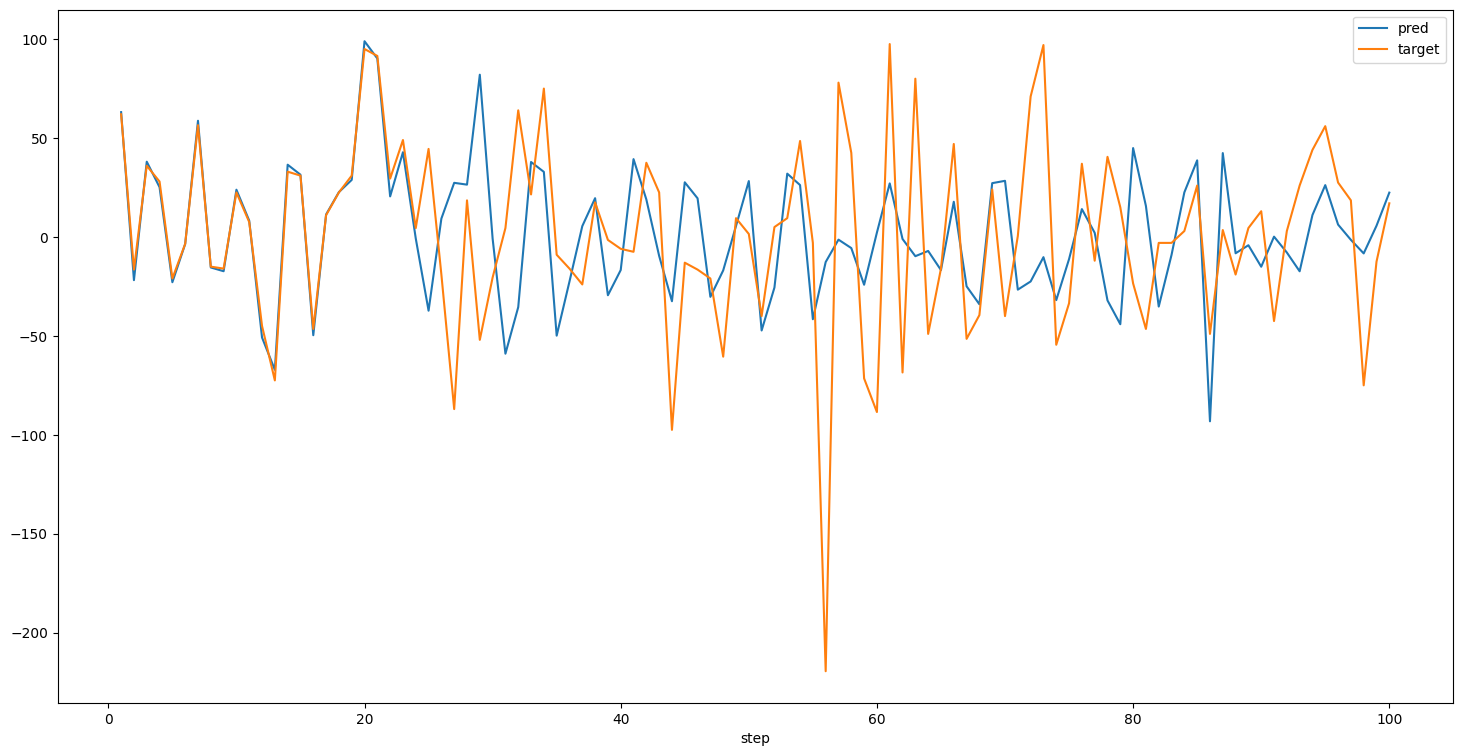

In [829]:
df_pred_vs_target.plot(x='step', y=['pred', 'target'], figsize=(18, 9))

## Examine outputs

In [33]:
X_after_train = torch.from_numpy(X_examples[228:229,:].astype('float32')).to(device=device).reshape(-1, 50 , 1)
y_after_train = y_examples[228:229]

In [34]:
output_after_train = xlstmtime(X_after_train)

In [35]:
output_after_train[:,-1,:]

tensor([[2171.7285]], device='cuda:0', grad_fn=<SliceBackward0>)

In [36]:
y_after_train

array([2151.])

In [38]:
X_examples[228:229,:]

array([[2384.5, 2350. , 2240.5, 2257. , 2266. , 2260.5, 2260. , 2241. ,
        2255. , 2142. , 2134. , 2140. , 2165. , 2142. , 2105.5, 2123.5,
        2108. , 2125. , 2163.5, 2150. , 2118. , 2142. , 2158. , 2159. ,
        2170. , 2132. , 2159. , 2183.5, 2170. , 2122.5, 2080. , 2100.5,
        2123.5, 2097. , 2070.5, 2145. , 2192. , 2117. , 2140. , 2152.5,
        2178. , 2202.5, 2196.5, 2213. , 2194. , 2195. , 2168. , 2136. ,
        2143.5, 2185.5]])

In [40]:
X_examples[229:231,:]

array([[2350. , 2240.5, 2257. , 2266. , 2260.5, 2260. , 2241. , 2255. ,
        2142. , 2134. , 2140. , 2165. , 2142. , 2105.5, 2123.5, 2108. ,
        2125. , 2163.5, 2150. , 2118. , 2142. , 2158. , 2159. , 2170. ,
        2132. , 2159. , 2183.5, 2170. , 2122.5, 2080. , 2100.5, 2123.5,
        2097. , 2070.5, 2145. , 2192. , 2117. , 2140. , 2152.5, 2178. ,
        2202.5, 2196.5, 2213. , 2194. , 2195. , 2168. , 2136. , 2143.5,
        2185.5, 2151. ],
       [2240.5, 2257. , 2266. , 2260.5, 2260. , 2241. , 2255. , 2142. ,
        2134. , 2140. , 2165. , 2142. , 2105.5, 2123.5, 2108. , 2125. ,
        2163.5, 2150. , 2118. , 2142. , 2158. , 2159. , 2170. , 2132. ,
        2159. , 2183.5, 2170. , 2122.5, 2080. , 2100.5, 2123.5, 2097. ,
        2070.5, 2145. , 2192. , 2117. , 2140. , 2152.5, 2178. , 2202.5,
        2196.5, 2213. , 2194. , 2195. , 2168. , 2136. , 2143.5, 2185.5,
        2151. , 2143. ]])

In [5]:
left_t = torch.randn(1, 50, 1)
right_t = torch.randn(1, 1, 1)

res_t = torch.cat((left_t, right_t), dim=1)[:, 1:, :]

In [6]:
res_t.shape

torch.Size([1, 50, 1])